In [1]:
"""
this block is needed at the beginning of all notebooks to be able to load modules
"""
import os
import sys
from pathlib import Path
import pandas as pd
import math
import numpy as np
from scipy.signal import detrend

# Automatically find and append the project root
root_path = Path.cwd().resolve().parents[1]  # adjust level as needed
data_path = os.path.join(root_path, "data")
src_path = os.path.join(root_path, "src")

if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))


In [2]:
from signal_generator.signal_module import SignalModule
from signal_generator.regression.Kalman_filter import KalmanFilter

In [3]:
noise = 1e-3
kalman = KalmanFilter(process_noise=noise, obs_noise_scale=3 * noise)

In [4]:
from signal_generator.asset_grader import GraderPctReturn, GraderPctReturnVolAdj
from signal_generator.signal_normalizer import NormalizerRank, NormalizerVolAdj, NormalizerTrivial

signal_module = SignalModule(
    oracle=kalman, 
    smoothing_window=1,
    asset_grader=GraderPctReturnVolAdj(),
    normalizer=NormalizerTrivial(),
    # normalizer=NormalizerRank(),
)

In [5]:
initial_time = pd.to_datetime('2023-06-01T12:00:00+00:00')
final_time = pd.Timestamp('2024-01-01T12:00:00+00:00')

tickers = ["SPY", "NVDA", "TSLA", "BRK-B"]  # List of tickers
data_files = [os.path.join(data_path, f"{ticker}.parquet") for ticker in tickers]
data = {
    ticker: pd.read_parquet(path).loc[initial_time:final_time]
    for ticker, path in zip(tickers, data_files)
}
timeline = pd.DatetimeIndex(
    pd.to_datetime(sorted(set().union(*[df.index for df in data.values()])))
)
data = {tk: df.reindex(timeline).ffill() for tk, df in data.items()}
closing_data = {tk: df['adjClose'] for tk, df in data.items()}

In [6]:
from signal_generator.signal_diagnostics import SignalDiagnostics
diagnostics = SignalDiagnostics(signal_module=signal_module, lookback=40)

In [7]:
signal_module.generate_signals({tk: s[-40:-1] for tk, s in closing_data.items()})

SignalResult(signals=array([ 0.93856541,  0.58444173, -1.        ,  0.45629285]), raw_predictions=array([468.28610957,  49.32377249, 255.54033994, 357.18819958]), volatility_adjustments=array([3.31270402, 1.15855043, 0.79089425, 3.0939487 ]), tickers=['SPY', 'NVDA', 'TSLA', 'BRK-B'])

Processing timeline: 100%|██████████| 106/106 [00:04<00:00, 21.64it/s]


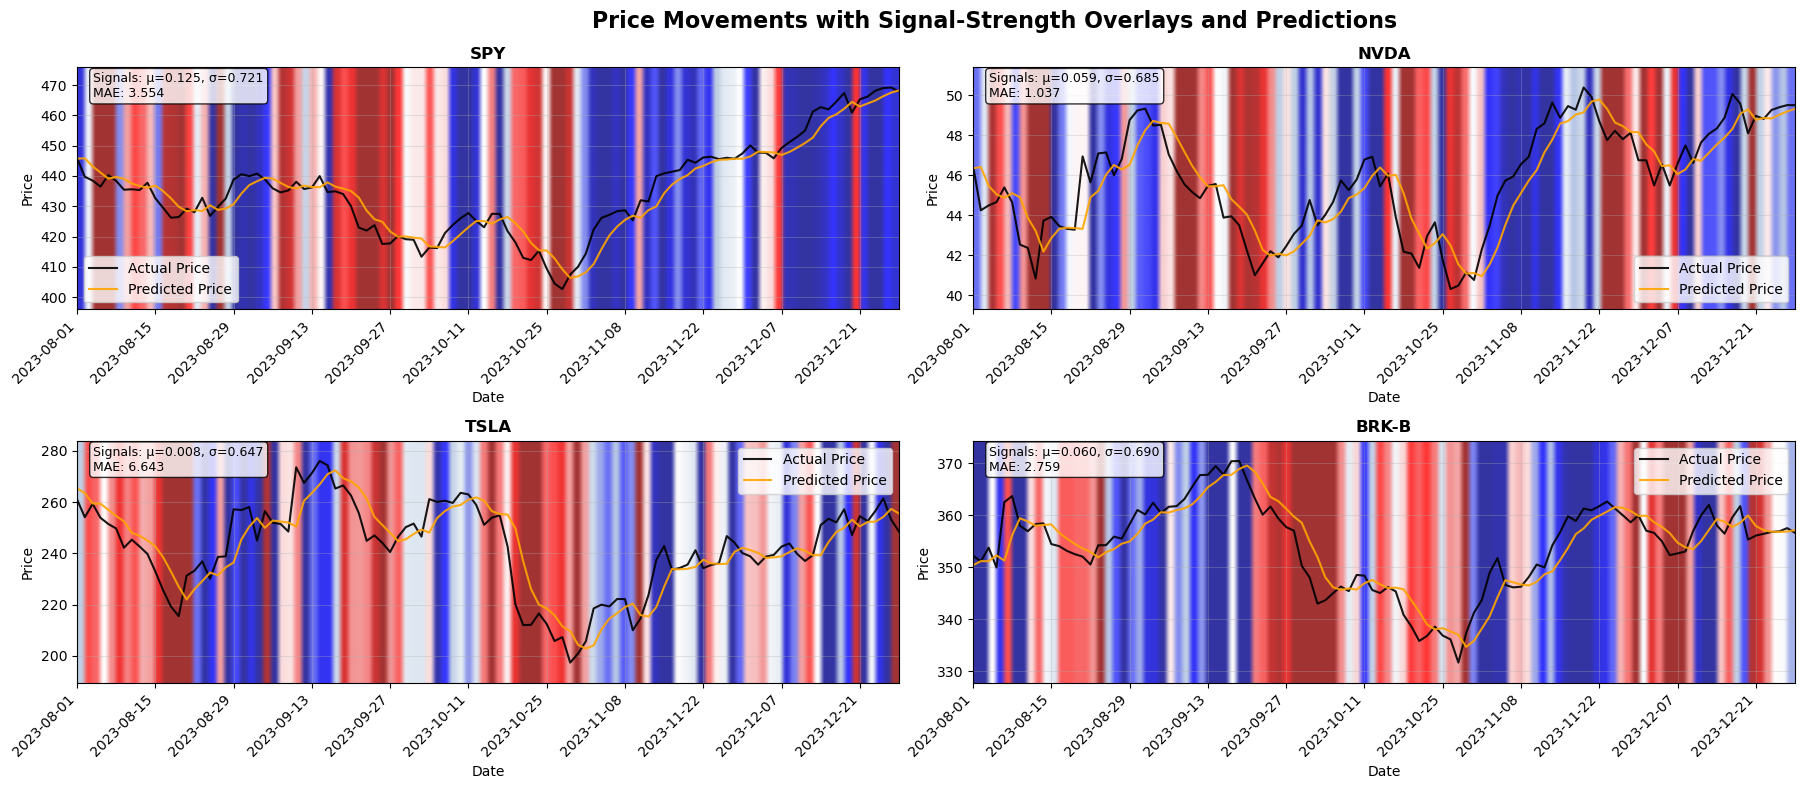


DIAGNOSTIC SUMMARY
Analysis period: 2023-08-01 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
Number of signal observations: 106
Smoothing window used: 1 days

Signal Statistics by Ticker:
----------------------------------------
     SPY: μ=+0.125, σ=0.721, range=[-1.000, +1.000]
    NVDA: μ=+0.059, σ=0.685, range=[-1.000, +1.000]
    TSLA: μ=+0.008, σ=0.647, range=[-1.000, +1.000]
   BRK-B: μ=+0.060, σ=0.690, range=[-1.000, +1.000]

Prediction Accuracy by Ticker:
----------------------------------------
     SPY: MAE=3.554, MAPE=0.82%
    NVDA: MAE=1.037, MAPE=2.29%
    TSLA: MAE=6.643, MAPE=2.78%
   BRK-B: MAE=2.759, MAPE=0.78%

Signal Correlation Matrix:
------------------------------
             SPY    NVDA    TSLA   BRK-B
     SPY   1.000   0.549   0.544   0.437
    NVDA   0.549   1.000   0.353   0.111
    TSLA   0.544   0.353   1.000   0.144
   BRK-B   0.437   0.111   0.144   1.000


In [8]:
diagnostics.run(data=closing_data)